# Example 12: Generating Standard f(z)

# Introduction

In this example, we calcuate $f_c(z)$ using main.evolve() without backreaction to generate what we call our _baseline f(z)_.  First, we demonstrate that our code is capable of matching previous results.  So we generate Fig. 22 of 1604.02457 by turning off some of the improvements introduced in DarkHistory.  Next, and finally, we turn back on the improvements introduced in DarkHistory and update Fig. 22 of 1604.02457, which will then give us $f_c(z,m_\chi)$, i.e. our baseline f(z).

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload
import numpy as np

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
import darkhistory.spec.spectools as spectools
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d

import main

In [3]:
%matplotlib inline

## Comparison to 1604.02457

First we must set parameters to those used in 1604.02457

In [4]:
import darkhistory.physics as phys
phys.kB = 8.6173423e-5
phys.G = 6.6730e-8

kmperMpc = 3.08568025e19
amuperg = 6.0221415e23
eVperg = 5.60958921e32
nh0 = 0.022068*(1e2/kmperMpc)**2*amuperg*3/(8*np.pi*phys.G)

phys.omega_m       = 0.3175
phys.omega_rad     = 8e-5
phys.omega_lambda  = 0.6825
phys.omega_baryon  = 8*np.pi*phys.G/(3*phys.H0**2) * (nh0/amuperg)
phys.omega_DM      = phys.omega_m-phys.omega_baryon

phys.rho_DM=1274.4140

phys.nB = nh0
phys.rho_baryon = nh0*phys.mp

phys.YHe = .24

def TCMB(rs):
    fac = 2.725
    return fac * phys.kB * rs
phys.TCMB = TCMB

We will start by picking a DM mass making sure that we reproduce the correct f(z)'s for $\chi \to \gamma \gamma$ and $\chi \to e^+ e^-$. Then we will proceed to generate f(z)'s for decay, s-wave annihilation, and p-wave annihilation over a range of dark matter masses.

Either way, we're going to need the f(z)'s produced by IDL for the 1604.02457:

In [5]:
# Directory that contains all of the f(z)'s used in 1604.02457
user = '/Users/gregoryridgway'
direc = user+'/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'

In [6]:
from astropy.io import fits
import darkhistory.spec.spectools as spectools

float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)

# Input energy abscissa
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

# List of f(z)'s used in 1604.02457
f_idl_list = np.zeros((2, len(log10eng),6398,5))
for k,inj_str in enumerate(['elec', 'phot']):
    if inj_str == 'elec':
        mass = phys.me
    else:
        mass = 0
        
    rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6398)]
    for i, en in enumerate(log10eng[:-1]):
        hdul = fits.open(
            direc+inj_str+'/calcfracs_tf_z_3.000E+03_nstep_6398_logE_'
            +float_formatter(np.log10(10**en+mass), 3)+'_xe_0.000E+00.fits'
        )

        data = hdul[1].data

        f_idl_low  = data.field('loweng_deposition_fractions')[0]
        f_idl_high = data.field('higheng_deposition_fractions')[0]
        idl_redshift     = data.field('redshift')[0]

        f_idl_list[k,i,:] = np.swapaxes(f_idl_low + f_idl_high,0,1)

        hdul.close()

### IDL comparison for a single, fixed DM mass

First, $\chi \to \gamma \gamma$ with $m_\chi$ set to the 10th energy value.

In [54]:
%autoreload
mDM = 2*10**log10eng[10]
DH_run = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=mDM, lifetime=3e25,
    start_rs = 3000, end_rs=5,
    coarsen_factor=4, backreaction=False, cross_check = True
)

In [55]:
single_DH_run_fs = np.array(
    [DH_run['f']['low'][channel]  + DH_run['f']['high'][channel] 
     for channel in ['H ion', 'He ion', 'exc', 'heat', 'cont']]
)

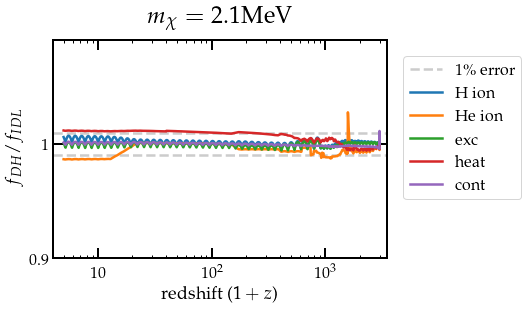

In [73]:
plt.figure()
ax = plt.gca()
ax.loglog()
plt.axis([4,3.5e3,.9,1.1])
line1 = plt.axhline(1 + .01,color='gray',linestyle='--',alpha=0.4, label='1\% error')
line2 = plt.axhline(1 - .01,color='gray',linestyle='--',alpha=0.4)

# loop over the different channels
plts = [None for i in np.arange(5)]
for i,chan in enumerate(['H ion', 'He ion', 'exc', 'heat', 'cont']):
    plts[i], = plt.plot(
        DH_run['rs'][:],
        (single_DH_run_fs[i,:]+1e-20)/(f_idl_list[1,10,::4,i]+1e-20), label=chan
    )
plt.legend(handles=[line1, *plts])
ax.legend(bbox_to_anchor=(1.0, 1.0))

plt.title(r'$m_\chi = 2.1$MeV')
plt.ylabel(r'$f_{DH}/f_{IDL}$')
plt.xlabel(r'redshift ($1+z$)')
plt.show()

### IDL comparison sweeping over injection energies

Here we loop over 40 different injection energies and compare against our IDL results

In [ ]:
f_DH_list = np.zeros((40,1600,5))

In [31]:
DH_run_crossCheck = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=2*10**log10eng[15], lifetime=3e25,
    start_rs = 3000, end_rs=5,
    coarsen_factor=4, backreaction=False, cross_check = True
)

In [32]:
DH_run_noCrossCheck = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=2*10**log10eng[15], lifetime=3e25,
    start_rs = 3000, end_rs=5,
    coarsen_factor=4, backreaction=False, cross_check = False
)

In [40]:
rs_vec = DH_run_crossCheck['rs']
f_cross_check = DH_run_crossCheck['f']['low']['heat'] + DH_run_crossCheck['f']['high']['heat']
f_no_cross_check = DH_run_noCrossCheck['f']['low']['heat'] + DH_run_crossCheck['f']['high']['heat']
f_std=phys.f_std(
        2*10**log10eng[15], 
        rs_vec, 
        inj_particle='phot', 
        inj_type='decay', 
        struct=False, 
        channel='heat')

In [52]:
f_std_data = pickle.load(
    open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/f_std_data/f_std_data.p','rb'))

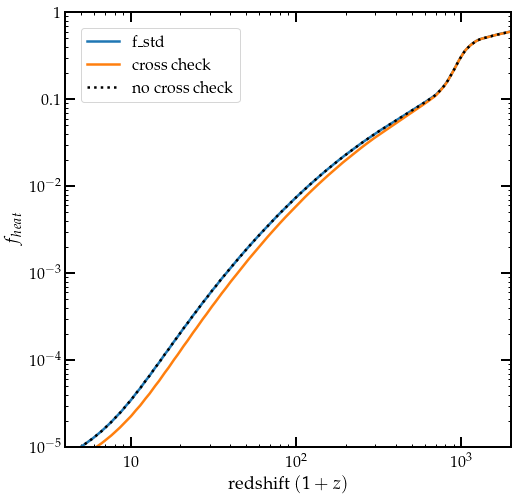

In [50]:
plt.figure(figsize=(8,8))
ax = plt.gca()
ax.loglog()

plt.axis([4,2e3,1e-5,1])
plt_std, = plt.plot(rs_vec, f_std, label=r'f\_std')
plt_cross_check, = plt.plot(rs_vec, f_cross_check, label=r'cross check')
plt_no_cross_check, = plt.plot(rs_vec, f_no_cross_check, label=r'no cross check', color='k', linestyle = ':')
plt.xlabel(r'redshift $(1+z)$')
plt.ylabel(r'$f_{heat}$')

plt.legend(handles=[plt_std,plt_cross_check,plt_no_cross_check])
plt.show()

In [140]:
%autoreload
for i,eng in enumerate(tqdm(log10eng)):
    mDM = 2*10**eng
    DH_run = main.evolve(
        primary='phot_delta',
        DM_process='decay', mDM=mDM, lifetime=3e25,
        start_rs = 3000, end_rs=5,
        coarsen_factor=4, backreaction=False, cross_check = True
    )

    f_DH_list[i] = np.swapaxes(np.array(
        [DH_run['f']['low'][channel]  + DH_run['f']['high'][channel] 
        for channel in ['H ion', 'He ion', 'exc', 'heat', 'cont']]
    ),0,1)

In [7]:
%autoreload
f_DH_list_elec = np.zeros((40,200,5))
for i,eng in enumerate(tqdm(log10eng)):
    mDM = 2*(10**eng + phys.me)
    DH_run = main.evolve(
        primary='elec_delta',
        DM_process='decay', mDM=mDM, lifetime=3e25,
        start_rs = 3000, end_rs=5,
        coarsen_factor=32, backreaction=False, cross_check = True
    )

    f_DH_list_elec[i] = np.swapaxes(np.array(
        [DH_run['f']['low'][channel]  + DH_run['f']['high'][channel] 
        for channel in ['H ion', 'He ion', 'exc', 'heat', 'cont']]
    ),0,1)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


#### Functions for contour plots

In [10]:
def get_fcontour(f_input, inj_type, inj_particle, channel):
    f_for_plot = f_input.copy()
    eng = 10**log10eng
    coarsen_factor=round(6398/f_for_plot.shape[-1])

    ind = {'H_ion' : 0, 'He_ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H_ion' : 'H_{ion}', 'He_ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    else:
        if inj_particle == 'phot':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 50, 200])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1, 5, 10,100])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 100, 500])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 100])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 500])
        elif inj_particle == 'elec':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 10000])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 2e-3, 1e-2, 1e-1, 10, 50, 1000])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 5000])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 10, 100, 1000, 10000])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 10, 100, 1000, 10000])
                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,idl_redshift[::coarsen_factor],
                     np.transpose(f_for_plot[:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.inferno)
#                      cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,idl_redshift[::coarsen_factor],
               np.transpose(f_for_plot[:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')
    
#     plt.savefig(
#         cwd+'/../../../f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.png'
#     )

    plt.show()

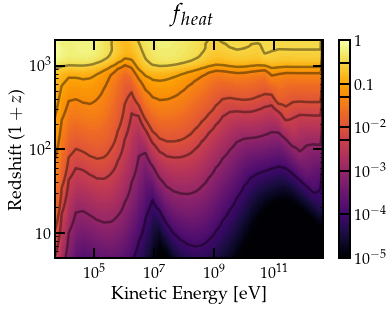

In [109]:
tmp = np.swapaxes(f_idl_list[1],1,2)
get_fcontour(tmp, 'decay', 'phot', 'heat')

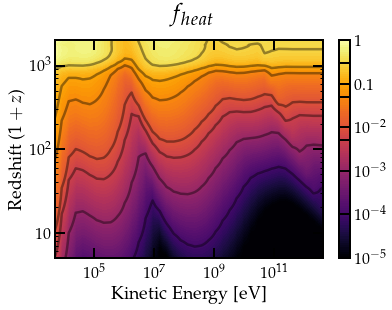

In [141]:
get_fcontour(np.swapaxes(f_DH_list,1,2), 'decay', 'phot', 'heat')

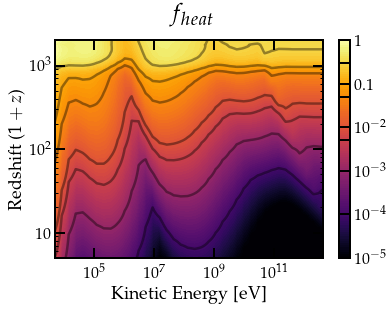

In [62]:
get_fcontour(np.swapaxes(f_std_data['phot_decay'][:,:6398],1,2), 'decay', 'phot', 'heat')

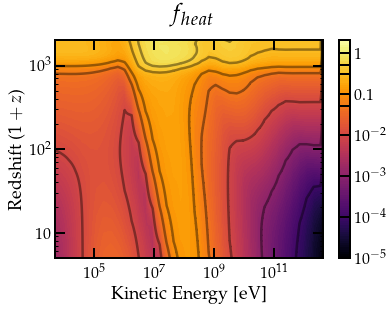

In [12]:
tmp_elec = np.swapaxes(f_idl_list[0],1,2)
get_fcontour(tmp_elec, 'decay', 'elec', 'heat')

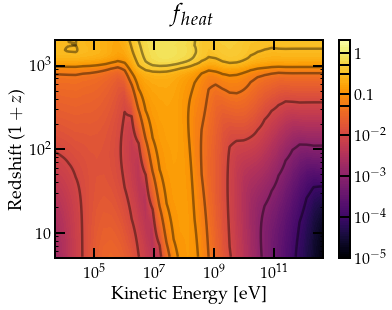

In [13]:
get_fcontour(np.swapaxes(f_DH_list_elec,1,2), 'decay', 'elec', 'heat')

In [70]:
f_std_func_list=np.array([phys.f_std(
        2*10**en, 
        rs_vec, 
        inj_particle='phot', 
        inj_type='decay', 
        struct=False, 
        channel='heat') for en in log10eng])

In [74]:
def get_fdiff(inj_type, inj_particle, channel):
    ind = {'H ion' : 0, 'He ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H ion' : 'H_{ion}', 'He ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    
    if inj_particle == 'phot':
#         f_DH_tmp = f_DH_list[:,:,ind]
        f_DH_tmp = f_std_data['phot_decay'][:,:6398:4,ind]
        coarsen_factor=4
        indd = 1
    else:
        f_DH_tmp = f_DH_list_elec[:,:,ind]
        coarsen_factor=32
        indd = 0
        
    folder = inj_str+'_'+inj_type+'/'
    
    eng = 10**log10eng   

    rs_list = np.array([3000*np.exp(-0.001*coarsen_factor*i) for i in np.arange(np.round(6398/coarsen_factor))])

    plt.figure()
    ax=plt.gca()
    ax.loglog()
    levels=[0,.01,.05,.1,.2,.3,.4,.5]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_DH_tmp)
#     diffs = np.abs(
#         f_DH_tmp - f_idl_list[indd,:,::coarsen_factor,ind]
#     )/f_idl_list[indd,:,::coarsen_factor,ind]
    
    diffs = np.abs(
        f_DH_tmp - f_std_func_list
    )/f_std_func_list
    print(diffs)
    
    cs2 = ax.contourf(eng, rs_list, np.transpose(diffs), levels = levels,
                     cmap=matplotlib.cm.RdBu_r)
    cbar = plt.colorbar(cs2, ticks=levels)
    
    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

#     plt.savefig(
#         '/Users/gregoryridgway/Desktop/4_14_DH_idl_comparisons/f'+inj_particle+'_'+inj_type+'_'+channel+'_IDLdiffs.png'
#     )
    plt.show()

[[1.00000000e+00 5.70796100e-04 4.21550418e-04 ... 4.40984152e-04
  4.41067129e-04 4.41149923e-04]
 [1.00000000e+00 1.91139669e-16 1.03764949e-13 ... 4.40932358e-13
  4.42995245e-13 4.43797791e-13]
 [1.00000000e+00 2.28948465e-16 1.12045528e-13 ... 4.73184339e-13
  4.74347534e-13 4.74186370e-13]
 ...
 [1.00000000e+00 2.16758267e-16 1.74483383e-13 ... 1.16083470e-12
  1.16220339e-12 1.16053372e-12]
 [1.00000000e+00 0.00000000e+00 1.74335747e-13 ... 1.21055995e-12
  1.21152343e-12 1.21192104e-12]
 [1.00000000e+00 3.22603441e-09 2.62840999e-09 ... 1.24486108e-05
  1.24388565e-05 1.24290911e-05]]


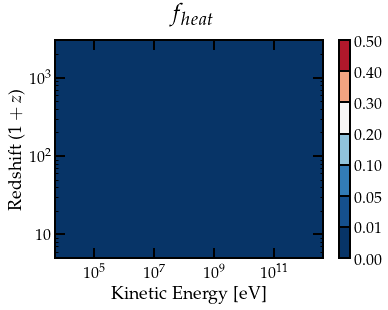

In [75]:
get_fdiff('decay', 'phot', 'heat')

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


(1600,)


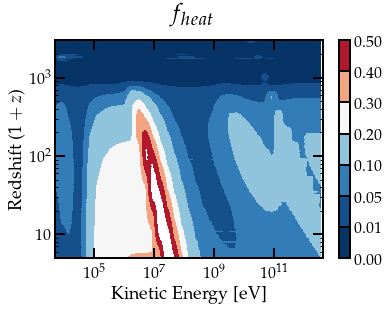

In [69]:
get_fdiff('decay', 'phot', 'heat')

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(1600,)


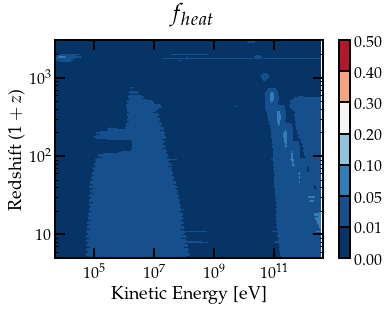

In [147]:
get_fdiff('decay', 'phot', 'heat')

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


(200,)


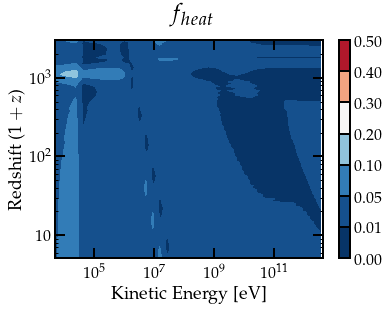

In [28]:
get_fdiff('decay', 'elec', 'heat')

#### Contour plots demonstrating the residual differences between 

## Generate files for physics.f_std()

First, we must set our parameters back to PLANCK 2018 parameters

In [6]:
phys.kB = 8.6173324e-5
phys.G = 6.6730e-8

phys.omega_m       = 0.3153
phys.omega_rad     = 8e-5
phys.omega_lambda  = 0.6847
phys.omega_baryon  = 0.02237/(phys.h**2)
phys.omega_DM      = 0.1200/(phys.h**2)

phys.rho_DM=phys.rho_crit*phys.omega_DM

phys.rho_baryon = phys.rho_crit*phys.omega_baryon
phys.nB = phys.rho_baryon/phys.mp

phys.YHe = 0.245

def TCMB(rs):
    fac = 2.7255
    return fac * kB * rs

phys.TCMB = TCMB

8.6173423e-05

It will also be convenient to have a function that can save large amounts of data.

In [12]:
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

# Compute DH f(z)'s

In [167]:
%autoreload

labels = ['phot_decay', 'elec_decay',
          'phot_swave_noStruct', 'elec_swave_noStruct',
          'phot_swave_einasto', 'elec_swave_einasto',
          'phot_swave_NFW', 'elec_swave_NFW']

f_std_data = {label : np.zeros((40,6620,5)) for label in labels}

for label in tqdm(labels[7:]):
    for i,eng in enumerate(tqdm(log10eng)):
        #injection energy, DM mass, center-of-mass energy
        if label[:4] == 'elec':
            mass = phys.me
            pri = 'elec'
        else:
            mass = 0
            pri = 'phot'
        
        Einj = 10**log10eng[i]
        mDM = 2*Einj + 2*mass
        if label[5:] != 'decay':
            mDM = mDM/2
            DM_process='swave'
        else:
            DM_process='decay'
            
        if label[-7:] == 'einasto':
            struct_func = phys.struct_boost_func(model='einasto_subs')
        elif label[-3:] == 'NFW':
            struct_func = phys.struct_boost_func(model='NFW_no_subs')
        else:
            struct_func = None
            
        DH_run = main.evolve(
            primary = pri+'_delta',
            DM_process=DM_process, mDM=mDM, lifetime=3e25, sigmav=3e-28,
            start_rs = 3000, end_rs=4.004,
            coarsen_factor=1, backreaction=False, cross_check = False,
            struct_boost=struct_func
        )

        f_std_data[label][i] = np.swapaxes(np.array(
            [DH_run['f']['low'][channel]  + DH_run['f']['high'][channel] 
            for channel in ['H ion', 'He ion', 'exc', 'heat', 'cont']]
        ),0,1)
        
        save_as_pickled_object(f_std_data, user+'/Photon Deposition/f_std_data/f_std_data.p')

KeyboardInterrupt: 